In [1]:
import pandas as pd
import numpy as np

In [2]:
def load(file):
    """Load the experiment data from a CSV file with converter metrics."""
    
    schema = {
        'num_threads': np.int64(),
        'num_jsons_converted': np.int64(),
        'num_json_bytes_converted': np.int64(),
        'num_ipc': np.int64(),
        'ipc_bytes': np.int64(),
        'num_buffers_converted': np.int64(),
        't_parse': np.float64(),
        't_resize': np.float64(),
        't_serialize': np.float64(),
        't_thread': np.float64(),
        't_enqueue': np.float64(),
        'status': np.int64()
    }
    
    df = pd.read_csv(file, dtype=schema)

    # Make sure there were no errors for converters.
    assert(df['status'].sum() == len(df.index))
        
    return df

In [3]:
def analyze(df):
    """Analyze the experiment data, deriving various metrics such as throughput."""
    # Calculate time spent within the thread as 'other'.
    df['t_other'] = df['t_thread'] - df[['t_parse', 't_resize', 't_serialize', 't_enqueue']].sum(axis=1)
    
    # Calculate throughput
    df['Throughput (in)'] = df['json_bytes'] / df['t_thread']
    df['Throughput (out)'] = df['ipc_bytes'] / df['t_thread']
    
    df['Parse throughput (in)'] = df['json_bytes'] / df['t_parse']
    
    return df

In [4]:
def summarize(df):
    """Summarize the data from all threads into one row."""
    
    row = {'Threads': df['num_threads'].sum(),
             'JSONs': df['num_jsons'].sum(), 
             'Bytes (in)': df['json_bytes'].sum(), 
             'IPC messages': df['num_ipc'].sum(), 
             'Buffers parsed': df['num_parsed'].sum(), 
             # Take the mean of the time spent in threads:
             'Parse time': df['t_parse'].mean(),
             'Resize time': df['t_resize'].mean(), 
             'Serialize time': df['t_serialize'].mean(), 
             'Enqueue time': df['t_enqueue'].mean(), 
             'Other time': df['t_other'].mean(),
             'Thread time': df['t_thread'].mean(), 
             'Throughput (in)': df['Throughput (in)'].sum(),
             'Throughput (out)': df['Throughput (out)'].sum(),
             'Parse throughput (in)': df['Parse throughput (in)'].sum()}
              
    return row;

In [5]:
import glob

csv_files = []
for file in glob.glob("../experiments/data/battery/latency/threads/metrics/cpu/*.csv"):
    csv_files.append(file)

records = []
for file in csv_files:
    records.append(summarize(analyze(load(file))))


df = pd.DataFrame.from_records(records)
df.sort_values(by=['Threads', 'JSONs'], inplace=True)
df = df[df.JSONs == df.JSONs.max()]

df.set_index('Threads', inplace=True)

display(df)

,JSONs,Bytes (in),IPC messages,Buffers parsed,Parse time,Resize time,Serialize time,Enqueue time,Other time,Thread time,Throughput (in),Throughput (out),Parse throughput (in)
Threads,,,,,,,,,,,,,
1,16777216,834744832,16384,32,12.562300,0.028629,0.509945,0.001495,0.017431,13.119800,6.362481e+07,8.742684e+07,6.644841e+07
2,16777216,834744832,16384,64,7.256750,0.017072,0.238847,0.001301,0.542075,8.056045,1.036172e+08,1.423804e+08,1.150327e+08
3,16777216,834744832,16416,96,4.700880,0.011473,0.114015,0.001035,0.495435,5.322837,1.568233e+08,2.154921e+08,1.776086e+08
4,16777216,834744832,16384,128,3.968902,0.009489,0.094746,0.000683,0.515320,4.589140,1.818957e+08,2.499428e+08,2.105178e+08
5,16777216,834744832,16480,160,3.225850,0.007981,0.080697,0.000540,0.522968,3.838036,2.174927e+08,2.988615e+08,2.587896e+08
6,16777216,834744832,16512,192,2.701313,0.006988,0.061669,0.000460,0.746296,3.516727,2.373641e+08,3.261691e+08,3.095070e+08
7,16777216,834744832,16576,224,2.551427,0.006412,0.055667,0.000367,0.896088,3.509961,2.378217e+08,3.268016e+08,3.275883e+08
8,16777216,834744832,16384,256,2.217101,0.005520,0.049192,0.000268,0.884980,3.157061,2.644056e+08,3.633197e+08,3.779016e+08
9,16777216,834744832,16416,288,1.984764,0.005017,0.041925,0.000314,0.845453,2.877474,2.900963e+08,3.986235e+08,4.215541e+08


In [6]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 14
})

<AxesSubplot:xlabel='Threads'>

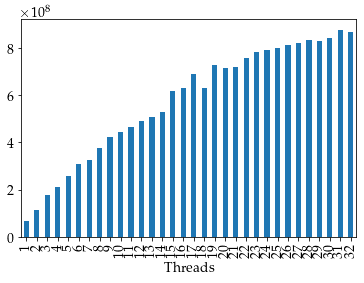

In [7]:
df['Parse throughput (in)'].plot.bar()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


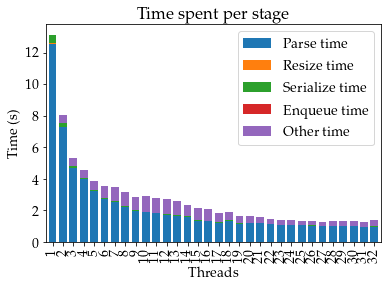

In [8]:
df_times = df[['Parse time', 'Resize time', 'Serialize time', 'Enqueue time', 'Other time']]
df_times.rename(columns={'Parse time': 'Parse', 
                         'Resize time': 'Resize', 
                         'Serialize time': 'Serialize', 
                         'Enqueue time': 'Enqueue', 
                         'Other time': 'Other'})
ax = df_times.plot.bar(stacked=True, 
                        width=0.75,
                        title='Time spent per stage',
                        ylabel='Time (s)')

In [9]:
from pywaffle import Waffle

wd = df_times.sum()

plt.figure(
    FigureClass=Waffle,
    rows=1,
    columns=100,
    values=wd,
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)}
)

plt.tight_layout()

wd

Parse time        69.771841
Resize time        0.157368
Serialize time     1.792971
Enqueue time       0.011515
Other time        17.135684
dtype: float64